<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/ITD_Based_MLP_KAN_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
%load_ext heat


In [37]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate multi-scale pattern data
def generate_data(n_samples=1000):
    X = np.linspace(0, 2 * np.pi, n_samples)

    # More complex slow-moving trend (sum of sinusoids with different frequencies)
    slow_trend = np.sin(2 * X) + 0.5 * np.tan(0.5 * X + np.pi / 4) + 0.5 * np.cos(0.7 * X + np.pi / 4)

    # Higher frequency oscillations with varying amplitudes
    fast_oscillations = 0.4 * np.sin(20 * X) + 0.2 * np.sin(30 * X + np.pi / 3)

    # More frequent and stronger spikes
    spikes = np.zeros_like(X)
    spike_indices = np.random.choice(n_samples, size=30, replace=False)  # Increased number of spikes
    spikes[spike_indices] = np.random.uniform(-2, 2, size=30)            # Stronger spikes

    # Increased noise level
    noise = 0.1 * np.random.randn(n_samples)

    # Combine all components
    y = slow_trend + fast_oscillations + spikes + noise

    return X.reshape(-1, 1), y.reshape(-1, 1)


import torch
import torch.nn as nn


class AcceleratedITDLayerEfficient_AkimaVectorized(nn.Module):
    def __init__(self, input_dim, output_dim, input_length, use_bias=False):
        """
        input_dim: Number of features per time point (typically 1)
        output_dim: Number of scales (grid resolutions)
        input_length: Fixed length of the input sequence
        use_bias: Whether to include a learnable per-scale bias.
        """
        super(AcceleratedITDLayerEfficient_AkimaVectorized, self).__init__()
        self.input_length = input_length
        self.output_dim = output_dim
        self.use_bias = use_bias

        # Create a per-scale bias parameter if needed (requires gradients)
        if use_bias:
            self.bias = nn.Parameter(torch.zeros((output_dim, 1), dtype=torch.float32))
        else:
            self.register_parameter('bias', None)

        # Precompute positions and register as buffer
        positions = torch.arange(input_length, dtype=torch.float32)
        self.register_buffer('positions', positions)

        # Store precomputed grids and basis functions as buffers (non-trainable)
        self.precomputed_grids = []
        self.precomputed_basis = []

        # Scales for grid resolutions
        scales = torch.linspace(2, input_length // 2, output_dim)

        for grid_size in scales:
            grid_size_int = int(grid_size.item())
            indices = torch.linspace(0, input_length - 1, grid_size_int).long()

            # Register grid indices as buffer (non-float, non-trainable)
            grid_name = f'grid_{grid_size_int}'
            self.register_buffer(grid_name, indices)
            self.precomputed_grids.append(getattr(self, grid_name))

            # Precompute normalized interpolation parameter `t`
            scale_factor = (grid_size_int - 1) / (input_length - 1)
            seg_idx = (positions * scale_factor).long().clamp(0, grid_size_int - 2)

            x_grid = indices.to(torch.float32)
            grid_start = x_grid[seg_idx]
            grid_end = x_grid[seg_idx + 1]
            delta = grid_end - grid_start + 1e-12  # Avoid zero division
            t = (positions - grid_start) / delta

            # Precompute cubic Hermite basis functions
            t2 = t * t
            t3 = t2 * t
            h00 = 2 * t3 - 3 * t2 + 1
            h10 = t3 - 2 * t2 + t
            h01 = -2 * t3 + 3 * t2
            h11 = t3 - t2

            # Stack basis functions and register as buffer
            basis = torch.stack([h00, h10, h01, h11], dim=0)  # shape: (4, L)
            basis_name = f'basis_{grid_size_int}'
            self.register_buffer(basis_name, basis)
            self.precomputed_basis.append(getattr(self, basis_name))

    def forward(self, x):
        batch, L, _ = x.shape
        outputs = []

        # Positions already on the correct device via register_buffer
        positions = self.positions

        for scale_idx, indices in enumerate(self.precomputed_grids):
            grid_size_int = indices.shape[0]

            # Extract grid point values (batch, grid_size_int)
            ext_vals = x[:, indices, 0]  # LongTensor indexing is fine here
            x_grid = indices.to(torch.float32)

            # Compute finite differences between adjacent grid points
            d = (ext_vals[:, 1:] - ext_vals[:, :-1]) / (x_grid[1:] - x_grid[:-1] + 1e-12)

            # Initialize slopes `m`
            m = torch.zeros((batch, grid_size_int), device=x.device, dtype=x.dtype)
            m[:, [0, 1, -2, -1]] = d[:, [0, 0, -1, -1]]  # Edge slopes

            # Apply Akima weighting
            if grid_size_int > 3:
                i_range = torch.arange(2, grid_size_int - 2, device=x.device)
                d_im2, d_im1, d_i, d_ip1 = d[:, i_range - 2], d[:, i_range - 1], d[:, i_range], d[:, i_range + 1]
                w1, w2 = (d_ip1 - d_i).abs(), (d_im1 - d_im2).abs()
                denom = w1 + w2 + 1e-12  # Small epsilon to avoid division by zero

                m[:, i_range] = torch.where(denom >= 1e-6,
                            (w1 * d_im1 + w2 * d_i) / (denom + 1e-12),
                            0.5 * (d_im1 + d_i))
            # Use precomputed basis functions
            h00, h10, h01, h11 = self.precomputed_basis[scale_idx]

            # Segment indices
            scale_factor = (grid_size_int - 1) / (L - 1)
            seg_idx = (positions * scale_factor).long().clamp(0, grid_size_int - 2)

            # Gather grid points for interpolation
            seg_idx_exp = seg_idx.unsqueeze(0).expand(batch, -1)
            seg_idx_plus = (seg_idx + 1).unsqueeze(0).expand(batch, -1)

            y0, y1 = torch.gather(ext_vals, 1, seg_idx_exp), torch.gather(ext_vals, 1, seg_idx_plus)
            m0, m1 = torch.gather(m, 1, seg_idx_exp), torch.gather(m, 1, seg_idx_plus)

            # Compute delta for scaling
            delta = (x_grid[1] - x_grid[0]).unsqueeze(0).expand(batch, L)

            # Apply precomputed basis functions
            baseline = h00 * y0 + h10 * m0 * delta + h01 * y1 + h11 * m1 * delta

            # Add per-scale bias if used
            if self.bias is not None:
                baseline += self.bias[scale_idx]

            outputs.append(baseline.unsqueeze(1))  # (batch, 1, L)

        return torch.cat(outputs, dim=1)  # (batch, output_dim, L)


# Vanilla MLP operating on the entire signal.
# It flattens the input (batch, L, 1) into (batch, L) and maps it to (batch, L) before reshaping.
class VanillaMLP(nn.Module):
    def __init__(self, input_length, hidden_dim, output_length):
        super(VanillaMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_length, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_length)
        )

    def forward(self, x):
        # x shape: (batch, L, 1) -> flatten to (batch, L)
        batch, L, _ = x.shape
        x_flat = x.view(batch, -1)
        out = self.fc(x_flat)
        # Reshape output to (batch, L, 1)
        return out.view(batch, L, 1)

# ITD-based MLP that uses the AcceleratedITDLayer.
# Note: It now takes an additional argument 'input_length' to know how many time steps to expect.
class ITDMLP(nn.Module):
    def __init__(self, input_length, hidden_dim, output_length):
        super(ITDMLP, self).__init__()
        # The ITD layer produces an output of shape (batch, hidden_dim, input_length)
        self.itd = AcceleratedITDLayerEfficient_AkimaVectorized(input_length=input_length, input_dim=1, output_dim=hidden_dim)
        self.fc = nn.Sequential(
            nn.GELU(),
            nn.Linear(hidden_dim * input_length, output_length)
        )

    def forward(self, x):
        # x shape: (batch, L, 1)
        x_itd = self.itd(x)         # -> (batch, hidden_dim, L)
        x_flat = x_itd.view(x_itd.size(0), -1)  # -> (batch, hidden_dim * L)
        out = self.fc(x_flat)       # -> (batch, output_length)
        return out.view(x.size(0), -1, 1)  # reshape to (batch, L, 1)

# Training loop
def train(model, X_train, y_train, epochs=500, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        if loss.item() < 1e-12:
            print(f"Early stopping at epoch {epoch}")
            break
    return losses

# Main demo
# Get data and add a batch dimension (batch size = 1)
X, y = generate_data(n_samples=1000)
X_train = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # shape: (1, 1000, 1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(0)  # shape: (1, 1000, 1)
input_length = X_train.shape[1]

# Initialize models
vanilla_mlp = VanillaMLP(input_length=input_length, hidden_dim=1, output_length=input_length)
itd_mlp = ITDMLP(input_length=input_length, hidden_dim=2, output_length=input_length)
dd =  itd_pred = itd_mlp(X_train)       # shape: (1000, 1)

# Train models


Training Vanilla MLP
Epoch 0, Loss: 503.5353
Epoch 50, Loss: 502.6815
Epoch 100, Loss: 502.3538
Epoch 150, Loss: 502.0326
Epoch 200, Loss: 501.7174
Epoch 250, Loss: 501.4081
Epoch 300, Loss: 501.1041
Epoch 350, Loss: 500.8051
Epoch 400, Loss: 500.5110
Epoch 450, Loss: 500.2216

Training ITD-based MLP
Epoch 0, Loss: 506.1776
Epoch 50, Loss: 120.9223
Epoch 100, Loss: 22.5964
Epoch 150, Loss: 2.4554
Epoch 200, Loss: 0.1428
Epoch 250, Loss: 0.0040
Epoch 300, Loss: 0.0000
Epoch 350, Loss: 0.0000
Epoch 400, Loss: 0.0000
Epoch 450, Loss: 0.0000


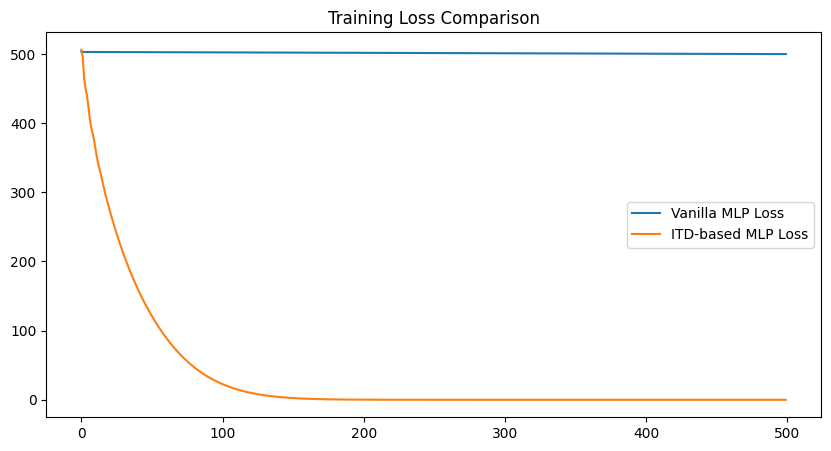

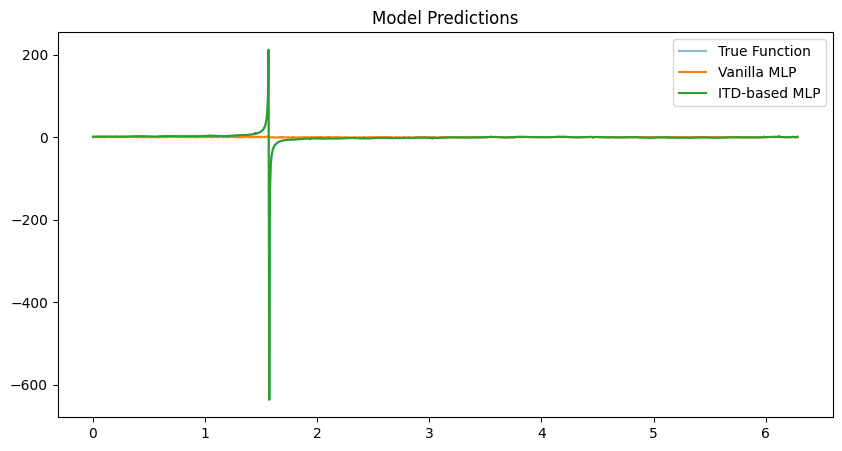

In [38]:

print("\nTraining Vanilla MLP")
vanilla_losses = train(vanilla_mlp, X_train, y_train)

print("\nTraining ITD-based MLP")
itd_losses = train(itd_mlp, X_train, y_train)

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(vanilla_losses, label="Vanilla MLP Loss")
plt.plot(itd_losses, label="ITD-based MLP Loss")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()

# Plot predictions (squeeze out batch and feature dimensions for plotting)
with torch.no_grad():
    vanilla_pred = vanilla_mlp(X_train).squeeze(0).cpu().numpy()  # shape: (1000, 1)
    itd_pred = itd_mlp(X_train).squeeze(0).cpu().numpy()          # shape: (1000, 1)

plt.figure(figsize=(10, 5))
plt.plot(X, y, label="True Function", alpha=0.5)
plt.plot(X, vanilla_pred, label="Vanilla MLP")
plt.plot(X, itd_pred, label="ITD-based MLP")
plt.legend()
plt.title("Model Predictions")
plt.show()



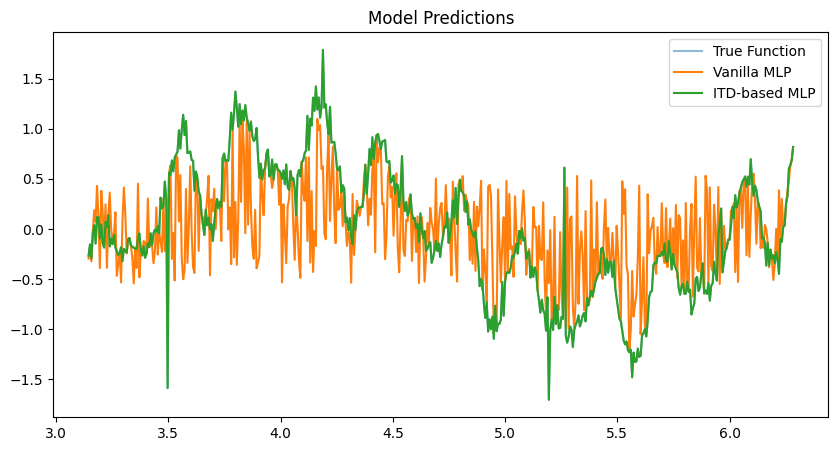

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(X[500:], y[500:], label="True Function", alpha=0.5)
plt.plot(X[500:], vanilla_pred[500:], label="Vanilla MLP")
plt.plot(X[500:], itd_pred[500:], label="ITD-based MLP")
plt.legend()
plt.title("Model Predictions")
plt.show()


In [12]:
%lprun -f itd_mlp(X_train)


/usr/local/lib/python3.11/dist-packages/line_profiler/ipython_extension.py:97: UserWarning: Could not extract a code object for the object tensor([[[ 5.4022e+00],
         [-2.6359e-01],
         [-1.5810e+00],
         [ 1.1752e+00],
         [-3.8502e+00],
         [-4.0829e+00],
         [ 2.4673e+00],
         [ 3.0408e-01],
         [-6.7484e-01],
         [ 2.1078e+00],
         [ 1.9639e+00],
         [-4.9491e-01],
         [ 4.4534e-01],
         [ 3.6847e-01],
         [ 1.6078e+00],
         [-2.1053e+00],
         [ 2.4288e+00],
         [-4.1026e+00],
         [-2.1946e+00],
         [-8.0992e-01],
         [-1.5843e+00],
         [-2.5138e+00],
         [-1.3847e+00],
         [ 2.5240e-01],
         [-1.6453e+00],
         [ 1.5604e+00],
         [-9.5706e-01],
         [ 1.0301e+00],
         [-1.2317e+00],
         [ 3.4052e-01],
         [-1.3959e+00],
         [-1.9496e+00],
         [-3.1086e+00],
         [ 6.4170e-01],
         [-1.2268e+00],
         [-2.4817e+00

In [15]:
!pip install line_profiler memory_profiler ipython py-heat-magic
%load_ext  heat

ModuleNotFoundError: No module named ' heat'

In [24]:
print(np.sum(np.abs(y-vanilla_pred)))
print(np.sum(np.abs(y-itd_pred)))


311.54521792793497
0.0002566774326232264
